In [3]:
# !git init .
# !git remote add origin https://github.com/kashparty/STP-GSR.git
# !git pull origin discriminator

In [4]:
# !pip install -r requirements.txt

# 3-Fold Cross-Validation

In [6]:
import os
import hydra
import torch
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import KFold
from hydra import compose, initialize

from src.train import train, eval
from src.plot_utils import plot_adj_matrices
from src.dataset import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="experiment")

torch.cuda.empty_cache()

if torch.cuda.is_available():
    print("Running on GPU")
else:
    print("Running on CPU")

kf = KFold(n_splits=config.experiment.kfold.n_splits, 
            shuffle=config.experiment.kfold.shuffle, 
            random_state=config.experiment.kfold.random_state)

# Initialize folder structure for this run
base_dir = config.experiment.base_dir
model_name = config.model.name
dataset_type = config.dataset.name
run_name = config.experiment.run_name
run_dir = f'{base_dir}/{model_name}/{dataset_type}/{run_name}/'

# Load dataset
source_data, target_data = load_dataset(config)

Running on GPU


In [ ]:
def main():
    res_dirs = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(source_data)):
        print(f"Training Fold {fold+1}/3")

        # Initialize results directory
        res_dir = f'{run_dir}fold_{fold+1}/'
        res_dirs.append(res_dir)
        if not os.path.exists(res_dir):
            os.makedirs(res_dir)

        # Fetch training and val data for this fold
        source_data_train = [source_data[i] for i in train_idx]
        target_data_train = [target_data[i] for i in train_idx]
        source_data_val = [source_data[i] for i in val_idx]
        target_data_val = [target_data[i] for i in val_idx]

        # Train model for this fold
        train_output = train(config, 
                              source_data_train, 
                              target_data_train,
                              source_data_val,
                              target_data_val, 
                              res_dir)

        # Evaluate model for this fold
        eval_output, eval_loss = eval(config, 
                                      train_output['model'], 
                                      source_data_val, 
                                      target_data_val, 
                                      train_output['criterion_L1'])

        # Final evaluation loss for this fold
        print(f"Final Validation Loss (Target): {eval_loss}")

        # Save source, taregt, and eval output for this fold
        np.save(f'{res_dir}/eval_output.npy', np.array(eval_output))
        np.save(f'{res_dir}/source.npy', np.array([s['mat'] for s in source_data_val]))
        np.save(f'{res_dir}/target.npy', np.array([t['mat'] for t in target_data_val]))


        # Plot predictions for a random sample
        idx = 6
        source_mat_test = source_data_val[idx]['mat']
        target_mat_test = target_data_val[idx]['mat']
        eval_output_t = eval_output[idx]

        plot_adj_matrices(source_mat_test, 
                          target_mat_test, 
                          eval_output_t, 
                          idx, 
                          res_dir, 
                          file_name=f'eval_sample{idx}')

    return res_dirs

res_dirs = main()

# Evaluating each fold

Processing fold from: results/stp_gsr/train/run4/fold_1/


  0%|          | 0/56 [00:40<?, ?it/s]


Processing fold from: results/stp_gsr/train/run4/fold_2/


  0%|          | 0/56 [00:40<?, ?it/s]


Processing fold from: results/stp_gsr/train/run4/fold_3/


  0%|          | 0/55 [00:40<?, ?it/s]


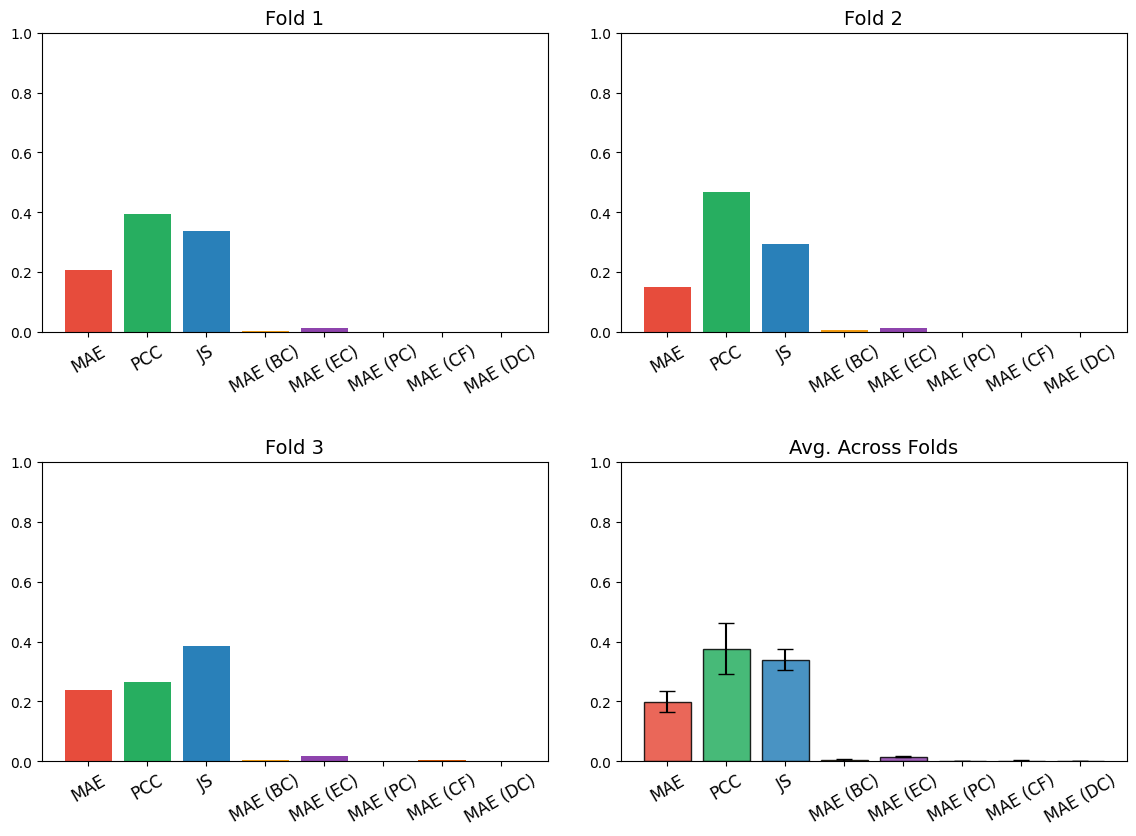

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
from hydra import compose, initialize
from src.models.stp_gsr import STPGSR
import torch
from tqdm import tqdm
from src.matrix_vectorizer import MatrixVectorizer


with initialize(version_base=None, config_path="configs"):
    config = compose(config_name="experiment")

metrics = ["MAE", "PCC", "JS", "MAE (BC)", "MAE (EC)", "MAE (PC)", "MAE (CF)", "MAE (DC)"]
fold_results = {m: [] for m in metrics}

# for each fold, compute fold metrics
for res_dir in res_dirs:
    print(f"Processing fold from: {res_dir}")

    pred_matrices = np.load(f'{res_dir}/eval_output.npy', allow_pickle=True)
    true_matrices = np.load(f'{res_dir}/target.npy', allow_pickle=True)

    mae_bc, mae_ec, mae_pc, mae_cf, mae_dc = [], [], [], [], []
    pred_1d_list, gt_1d_list = [], []

    for i in tqdm(range(len(pred_matrices))):
        # turn 0 connections into very small weights for numerical stability
        pred_matrices[i] = np.where(
            pred_matrices[i] == 0,
            1e-10 * np.ones_like(pred_matrices[i]),
            pred_matrices[i]
        )
        true_matrices[i] = np.where(
            true_matrices[i] == 0,
            1e-10 * np.ones_like(true_matrices[i]),
            true_matrices[i]
        )
        pred_graph = nx.from_numpy_array(pred_matrices[i])
        gt_graph = nx.from_numpy_array(true_matrices[i])

        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
        pred_pc = nx.pagerank(pred_graph, weight="weight")
        try:
            pred_cf = nx.current_flow_betweenness_centrality(pred_graph, weight="weight")
        except:
            pred_cf = None
        pred_dc = nx.degree_centrality(pred_graph)

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
        gt_pc = nx.pagerank(gt_graph, weight="weight")
        try:
            gt_cf = nx.current_flow_betweenness_centrality(gt_graph, weight="weight")
        except:
            gt_cf = None
        gt_dc = nx.degree_centrality(gt_graph)

        mae_bc.append(mean_absolute_error(list(pred_bc.values()), list(gt_bc.values())))
        mae_ec.append(mean_absolute_error(list(pred_ec.values()), list(gt_ec.values())))
        mae_pc.append(mean_absolute_error(list(pred_pc.values()), list(gt_pc.values())))
        if pred_cf is not None and gt_cf is not None:
            mae_cf.append(mean_absolute_error(list(pred_cf.values()), list(gt_cf.values())))
        mae_dc.append(mean_absolute_error(list(pred_dc.values()), list(gt_dc.values())))

        pred_1d_list.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d_list.append(MatrixVectorizer.vectorize(true_matrices[i]))

    # Aggregate per-fold results
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    fold_results["MAE"].append(mean_absolute_error(pred_1d, gt_1d))
    fold_results["PCC"].append(pearsonr(pred_1d, gt_1d)[0])
    fold_results["JS"].append(jensenshannon(pred_1d, gt_1d))
    fold_results["MAE (BC)"].append(np.mean(mae_bc))
    fold_results["MAE (EC)"].append(np.mean(mae_ec))
    fold_results["MAE (PC)"].append(np.mean(mae_pc))
    fold_results["MAE (CF)"].append(np.mean(mae_cf))
    fold_results["MAE (DC)"].append(np.mean(mae_dc))

# average over all folds, with error bars
means = [np.mean(fold_results[m]) for m in metrics]
stds = [np.std(fold_results[m]) for m in metrics]

custom_colors = ['#E74C3C', '#27AE60', '#2980B9', '#F39C12', '#8E44AD', '#1ABC9C', '#D35400', '#3498DB']

fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()

label_rotation = 30

for i, res_dir in enumerate(res_dirs):
    axes[i].bar(metrics, [fold_results[m][i] for m in metrics], color=custom_colors)
    axes[i].set_title(f'Fold {i+1}', fontsize=14)
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis='x', rotation=label_rotation, labelsize=12)

axes[3].bar(metrics, means, yerr=stds, capsize=6, color=custom_colors, alpha=0.85, edgecolor='black')
axes[3].set_title('Avg. Across Folds', fontsize=14)
axes[3].set_ylim(0, 1)
axes[3].tick_params(axis='x', rotation=label_rotation, labelsize=12)

plt.tight_layout(pad=3.0)
plt.show()

# Training final model and running predictions

In [ ]:
source_data, target_data = load_dataset(config)
base_dir = config.experiment.base_dir
model_name = config.model.name
dataset_type = config.dataset.name
run_name = config.experiment.run_name
run_dir = f'{base_dir}/{model_name}/{dataset_type}/{run_name}/'
res_dir = f'{run_dir}final_model/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

train_output = train(config, 
                        source_data, 
                        target_data,
                        [],
                        [], 
                        res_dir)
model = train_output['model']

Model parameters: 317,599
STPGSR(
  (target_edge_initializer): TargetEdgeInitializer(
    (conv1): TransformerConv(160, 67, heads=4)
    (bn1): GraphNorm(268)
  )
  (dual_learner): DualGraphLearner(
    (conv1): TransformerConv(3, 1, heads=1)
    (bn1): GraphNorm(1)
  )
  (discriminator): Discriminator(
    (dense_1): Dense()
    (relu_1): ReLU(inplace=True)
    (dense_2): Dense()
    (relu_2): ReLU(inplace=True)
    (dense_3): Dense()
    (sigmoid): Sigmoid()
  )
)


100%|██████████| 167/167 [08:15<00:00,  2.97s/it]


Epoch 1/60, Generator Loss: 0.20797904148073254, Discriminator Loss: 46.15617752217961


100%|██████████| 167/167 [08:16<00:00,  2.97s/it]


Epoch 2/60, Generator Loss: 0.17784497882434708, Discriminator Loss: 47.78415647952143


100%|██████████| 167/167 [08:18<00:00,  2.98s/it]


Epoch 3/60, Generator Loss: 0.16727893438167915, Discriminator Loss: 49.05846505536291


100%|██████████| 167/167 [08:15<00:00,  2.97s/it]


Epoch 4/60, Generator Loss: 0.16140236763540142, Discriminator Loss: 49.885060453129384


100%|██████████| 167/167 [08:18<00:00,  2.98s/it]


Epoch 5/60, Generator Loss: 0.15365816358320727, Discriminator Loss: 49.98956929281086


100%|██████████| 167/167 [08:19<00:00,  2.99s/it]


Epoch 6/60, Generator Loss: 0.14856991644747958, Discriminator Loss: 49.99906096772519


100%|██████████| 167/167 [08:19<00:00,  2.99s/it]


Epoch 7/60, Generator Loss: 0.14728058120626175, Discriminator Loss: 49.99812188976539


100%|██████████| 167/167 [08:16<00:00,  2.98s/it]


Epoch 8/60, Generator Loss: 0.14296900378372854, Discriminator Loss: 49.99713283241866


 41%|████▏     | 69/167 [03:25<04:47,  2.94s/it]

In [ ]:
from src.dataset import create_pyg_graph
from functools import partial
import numpy as np

source_vectorized = np.genfromtxt("lr_test.csv", delimiter=",", skip_header=1)
source_mat_all = [MatrixVectorizer.anti_vectorize(A, 160) for A in source_vectorized]

source_mat_all = [torch.tensor(x, dtype=torch.float) for x in source_mat_all]
pyg_partial = partial(create_pyg_graph, node_feature_init="adj", node_feat_dim=160)

source_pyg_all = [pyg_partial(x, 160) for x in source_mat_all]
source_data = [{'pyg': source_pyg, 'mat': source_mat} for source_pyg, source_mat in zip(source_pyg_all, source_mat_all)]

In [ ]:
from src.dual_graph_utils import revert_dual
model.eval()
eval_output = []

with torch.no_grad():
    for source in tqdm(source_data):
        source_g = source['pyg'].to(device)

        model_pred, _, _, _ = model(source_g, [])
        pred_m = revert_dual(model_pred, 268)    # (n_t, n_t)
        pred_m = pred_m.cpu().numpy()
        eval_output.append(pred_m)

eval_output

NameError: name 'model' is not defined

# Submission Generation code

In [ ]:
from src.matrix_vectorizer import MatrixVectorizer
import pandas as pd

test_array = np.concatenate([MatrixVectorizer.vectorize(eo) for eo in eval_output])

output_df = pd.DataFrame({"Predicted": test_array.flatten()})
output_df.index = np.arange(1, len(output_df) + 1)
output_df.to_csv("submission.csv", index_label="ID")
output_df